In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = "/kaggle/input/lfwdataset/lfw"

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [27]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


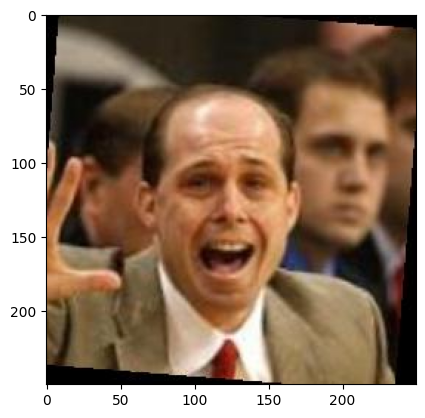

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [7]:
for x, y in dataloader:
    # Get the first image in the batch
    sample_image = x[0].permute(1, 2, 0)

    # Print the shape of the image tensor
    print("Image Shape:", sample_image.shape)
    h, w, c = sample_image.shape
    print(f"Height: {h}, Width: {w}, Channels: {c}")
    break


Image Shape: torch.Size([250, 250, 3])
Height: 250, Width: 250, Channels: 3


Dimensions:
Height: 250 pixels
Width: 250 pixels
Channels: 3 (indicating an RGB image with red, green, and blue color channels)

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=1 ,stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)

        # Decoder Layers
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.leaky_relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.leaky_relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = F.leaky_relu(self.dec_bn1(self.dec_conv1(x)))
        x = torch.sigmoid(self.dec_bn2(self.dec_conv2(x)))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x






**Architecture:**
This is an Autoencoder (AE) neural network architecture implemented in PyTorch. It consists of an encoder with two convolutional layers followed by batch normalization and a decoder with two transposed convolutional layers also followed by batch normalization. The encoder reduces the dimensionality of the input, and the decoder reconstructs the input. The activation function used is leaky ReLU in the encoder and decoder, with a sigmoid activation in the last layer of the decoder

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
# Creating an instance of the AE model
model = AE()


# Get a sample image from the dataloader
sample_image, _ = next(iter(dataloader))


encoded = model.encoder(sample_image)
decoded = model.decoder(encoded)


# Print the shapes of encoder and decoder outputs
print("Input Image Shape:", sample_image.shape)
print("Encoder Output Shape:", encoded.shape)
print("Decoder Output Shape:", decoded.shape)

Input Image Shape: torch.Size([32, 3, 250, 250])
Encoder Output Shape: torch.Size([32, 128, 64, 64])
Decoder Output Shape: torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print("Total Parameters in the Model:", total_params)

Total Parameters in the Model: 42697


In [12]:
loss_function = nn.MSELoss()

from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [22]:
# Move model to GPU or CPU
model = model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    for data in dataloader:
        inputs, _ = data  

        # Move inputs to GPU or CPU
        inputs = inputs.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = loss_function(outputs, inputs)  # MSE loss between input and output

        # Backward pass
        loss.backward()

        # Ensure that all model parameters and gradients are on the same device
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Report the loss at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")


Epoch [1/10], Average Loss: 0.0099
Epoch [2/10], Average Loss: 0.0082
Epoch [3/10], Average Loss: 0.0081
Epoch [4/10], Average Loss: 0.0081
Epoch [5/10], Average Loss: 0.0081
Epoch [6/10], Average Loss: 0.0080
Epoch [7/10], Average Loss: 0.0079
Epoch [8/10], Average Loss: 0.0079
Epoch [9/10], Average Loss: 0.0079
Epoch [10/10], Average Loss: 0.0078


It iterates through the dataset, calculates the Mean Squared Error loss between model outputs and inputs, updates model parameters, and reports the average loss after each epoch

**Loss value:**
If the loss value is not decreasing during training, it indicates that  model is not learning effectively. Here are several steps to troubleshoot and improve the situation:
1. Improve Learning rate : If the learning rate is too high, the optimization process might overshoot the minimum, preventing convergence. Conversely, if it's too low, the model might converge very slowly. Experiment with different learning rates to find the optimal value.
2.Inspect Model Complexity: If your model is too simple, it may struggle to capture the underlying patterns in the data. Consider increasing the model complexity by adding more layers or neurons, but be cautious of overfitting.
3.Increase Training Duration (Epochs):Sometimes, the model needs more time to learn from the data. Increase the number of training epochs and monitor the loss over time. However, be careful not to overfit the model to the training data.
4. Regularization Techniques: Implement regularization techniques such as L1 or L2 regularization to prevent overfitting.
5.Consider Alternative Optimizers: Experiment with different optimizers to see if the choice of optimizer impacts training.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

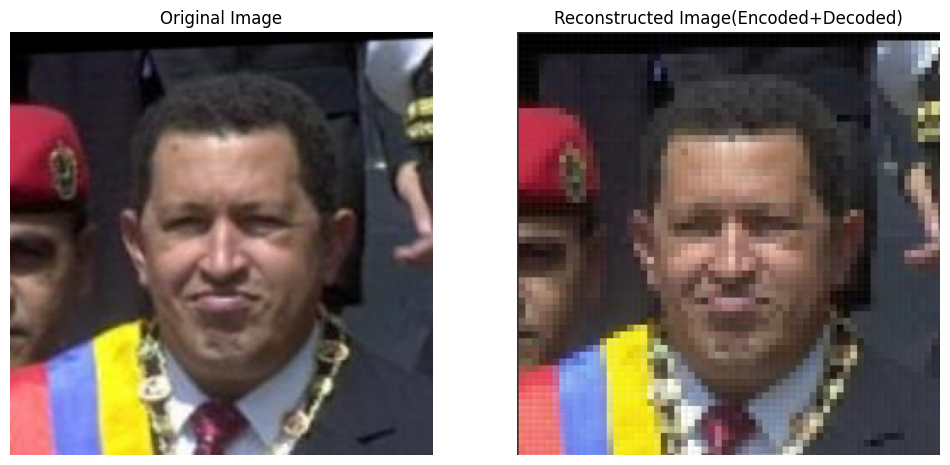

In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np


images, _ = next(iter(dataloader))

# Select a random image from the batch
random_image = images[torch.randint(len(images), (1,))]

if len(random_image.shape) == 3:  
    input_image = random_image.unsqueeze(0)  # Add batch dimension
else:
    input_image = random_image  

model.eval()
input_image = input_image.cuda() if torch.cuda.is_available() else input_image

# Perform inference
with torch.no_grad():
    reconstructed_image = model(input_image)

# Convert the images to numpy format for plotting
original_image_np = input_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title("Reconstructed Image(Encoded+Decoded)")
plt.axis('off')
plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

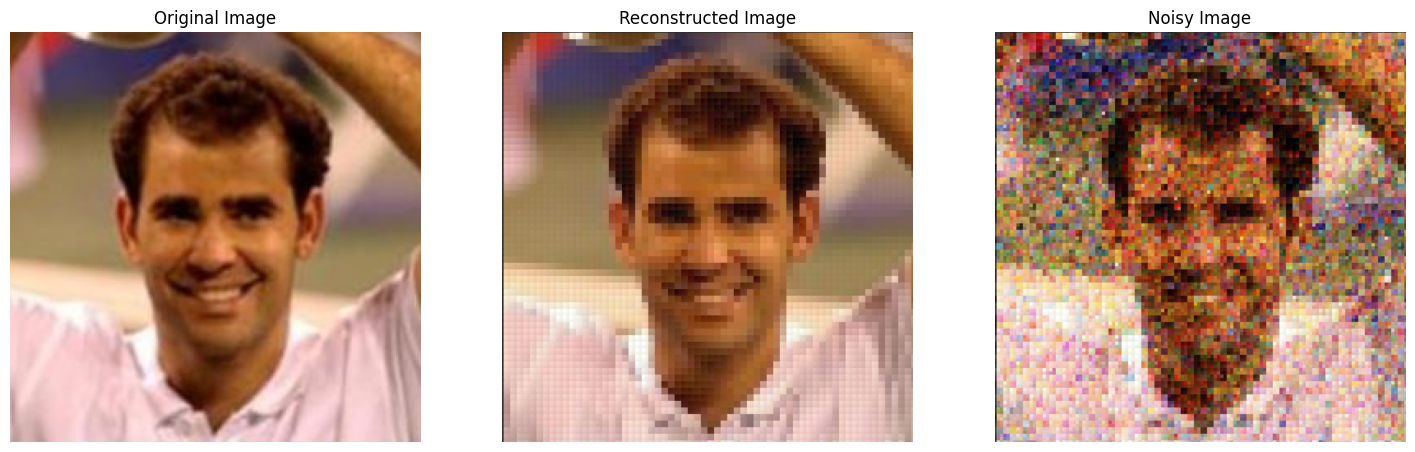

In [26]:
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

model.eval()
if torch.cuda.is_available():
    model.cuda()
    original_image = original_image.unsqueeze(0).cuda()
else:
    original_image = original_image.unsqueeze(0)

# Encode the image and add noise to the decoded image
with torch.no_grad():
    encoded_image = model.encoder(original_image)
    reconstructed_image = model.decoder(encoded_image)
    noise = torch.randn(encoded_image.shape) * 0.5
    if torch.cuda.is_available():
        noise = noise.cuda()
    noisy_encoded = encoded_image + noise
    noisy_reconstructed_image = model.decoder(noisy_encoded)

# Function to convert image for plotting
def to_plot(img):
    img = img.squeeze().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    return img

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(to_plot(original_image))
plt.axis('off')

# Plot reconstructed image
plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(to_plot(reconstructed_image))
plt.axis('off')

# Plot  noisy reconstructed image
plt.subplot(1, 3, 3)
plt.title("Noisy Image")
plt.imshow(to_plot(noisy_reconstructed_image))
plt.axis('off')

plt.show()


Adding small normally distributed noise to the latent representation of the input image and decoding it again has the following effects:

1.Smoothing and Denoising:
The noise added to the encoded image introduces controlled variability, leading to a smoother and potentially denoised appearance in the reconstructed image.

2.Enhanced Robustness:
The model, when trained with noisy latent representations, may become more robust to variations in the input data. This can improve the autoencoder's ability to handle uncertainties and variations in real-world scenarios.

3.Regularization:The introduced noise during training acts as a form of regularization, preventing overfitting and encouraging the model to learn more generalized features.